# Final Project - Patient Data Analysis

### Introduction to Data & Project Question

*Note: The data utilized for this analysis is private/confidential patient information data. For this reason I have witheld the source of my data.* <br>

A health clinic offers different resources for patients who have been in violent and/or abusive situations. These types of situations require therapy and clinical visits in order to heal and to feel normal again in life. Do some types of patients require more sessions/visits than others? Can we utilize the patient information to accurately predict the number of sessions a patient will need? These are the questions of interest. <br>

This analysis will look at multiple regression methods to determine what features indicate higher case sessions. The data is from a self-taken survey by each patient that visited the clinic. This survey contains all basic demographic information that would be recorded at a health clinic as well as the type of patient, the advocate or clinic assistant that helped the patient, and other clinical notes.  <br>

### Data Cleaning and Feature Engineering

*Note: The data cleaning for this dataset became very extensive. To make this report easier to read and more concise I created a separate notebook with the code of the data cleaning. The dataset imported into this notebook is the output of the cleaning notebook.*

The dataset originally came in a wide format. Each survey answer was a column. To make the data more usable I grouped answers from the same question together, condensed the columns from wide to long, and then merged them all together with the patient ID number (`Case Number`) as the key ID.  <br>

Many questions from the survey were not relevant to this analysis and were dropped (e.g. best communication method and TSA approval). We also created the `Case Count` feature that counts the number of times the patient visited the clinic. The original dataset contained 8 different case types, but because the dataset is small and only contains 343 unique patients, we condensed the case types into 4: <br>

    -Violence
    -Sexual Assault
    -Sexual Harassment
    -Other

After this process, the cleaned dataset contained demographic information, case/clinic visit information, advocate (the person at the clinic who helped them), the number of case sessions (`Case Count`), and the type of situation the victim had been in (`Case Type Modified`). <br>

In [121]:
# All Imported Packages
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import re

# regression stuff
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from warnings import filterwarnings
filterwarnings('ignore')

In [131]:
# read in data
pat_info = pd.read_csv('patient_data.csv')

In [141]:
pat_info.head()

,Unnamed: 0,Case Number,Enrollment Status,Date of Graduation,College/Major,Place of employment,Type of Contact,Gender,Sexual Orientation,Veteran Status,...,Working for Center for Disability and Access,International Student,Refugee Status/Background,Client status,Advocate,gender,Relation,Case Count,True Type,Case Type Modified
0,0,1,Transferred/left the U,NaN,NaN,NaN,Phone,Prefer not to disclose,Prefer not to disclose,Prefer not to disclose,...,Prefer not to disclose,No,Prefer not to disclose,Inactive (currently not engaged),A,She/Her,Student,30,Domestic Violence,Violence
1,1,1,Transferred/left the U,NaN,NaN,NaN,Phone,Prefer not to disclose,Prefer not to disclose,Prefer not to disclose,...,Prefer not to disclose,No,Prefer not to disclose,Inactive (currently not engaged),A,She/Her,Secondary Survivor (non-campus member),30,Domestic Violence,Violence
2,2,2,NaN,NaN,NaN,Academic advising,In person,Female,Prefer not to disclose,No,...,No,No,No,Inactive (currently not engaged),B,She/Her,Employee,7,Sexual Harassment,Sexual Harassment
3,3,3,Enrolled,NaN,College of Nursing,Unknown,In person,Female,Straight,No,...,No,No,No,Inactive (currently not engaged),B,She/Her,Student,4,Unknown,Other
4,4,3,Enrolled,NaN,College of Nursing,Unknown,In person,Female,Straight,No,...,No,No,No,Inactive (currently not engaged),B,She/Her,Employee,4,Unknown,Other


## Exploratory Data Analysis

**Case Count by Gender**

From the swarm plots, both the spread and count of each category of Gender can be seen. Our data has some class skewness because majority of the observations are female. With the other categories being much smaller, concluding the impact of gender on the case count will be more difficult.

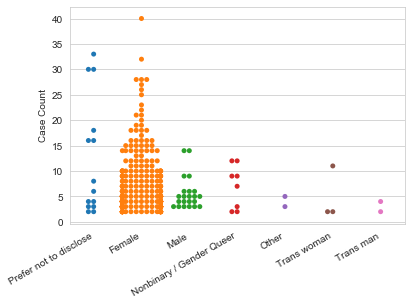

In [138]:
# Gender Swarm Plots
gen_box = sns.swarmplot(data=pat_info, x='Gender', y='Case Count')
gen_box.set_xticklabels(gen_box.get_xticklabels(), rotation=30, ha="right")
plt.xlabel('')
plt.show() # high female to all other ratio

**Case Count by Advocate**

From this swarm plot, we can see that majority of the high count cases were with advocates A, C, and D. This could indicate that A, C, and D are important features in determining case count. Practically speaking these advocates could be more experienced and used when clinic cases will require multiple visits. <br>

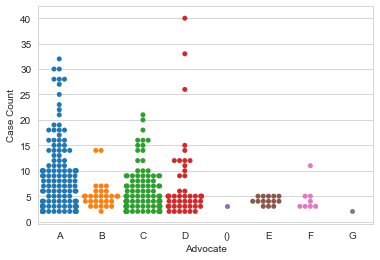

In [140]:
# Advocate Swarm Plots with color being case type
sns.swarmplot(data=pat_info, x='Advocate', y='Case Count')
plt.show()

#### Case Count by Case Type

Another question that we hope to answer in this analysis is if certain case types will require more clinic sessions than others. From this swarmplot we can see relatively equal distributions for all 4 case types.

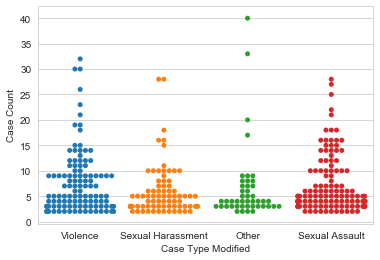

In [136]:
sns.swarmplot(data=pat_info, x='Case Type Modified', y = 'Case Count')
plt.show()

#### Overall Case Count Distribution

The number of cases per patient follows a right skewed distribution. We can see that majority of patients require under 10 visits and the rest follow a long right tail.

This could mean later that the MSE may be high because of a few outliers who are rightly skewed which will greatly penalize the MSE value.

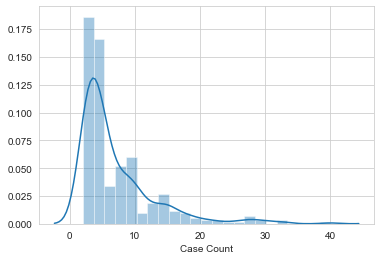

In [129]:
sns.distplot(pat_info['Case Count'])
plt.show()

## From the Features, Can We Predict the Case Count? 
### Regression Analysis

To answer this question we will need to utilize a regression Machine Learning technique. This data has a quantitative target and categorical features. We will look at 4 different models: <br>

    -Linear Regression
    -Lasso
    -KNN
    -Decision Tree

We chose these models because they can account for our categorical features and quantitative target of interest. To determine the best model we will look at the train MSE and the test MSE. The train MSE shows the mean squared error of our predictions for our train set, and the test MSE shows the mean squared error of our predictions for the test set. Looking at both shows us if our data is overfitting or not. <br>

Overfitting means that our model does well at predicting only for the training set (which is used to create our model), but when introduced to new data (test set) it does not predict well. This means we would be over confident in using our model and believe our predictions are more accurate than they truly are. To avoid this problem, we will look at the train MSE and test MSE. Whichever model has the lowest test MSE score will be used for the rest of the analysis. <br>

To *truly* identify the best model, we would need to take each model and fine tune them. However, for this analysis we will not be fine tuning each model method. We will utilize the default tuning parameters to calculate the MSE. <br>

#### Model Selection

Before analyzing, we will need to dummy code all the features that are categorical in order to make it usable for the models. After dummy coding we will then fit each model to the training and testing data sets. In order to make the analysis more robust I utilized KFold cross validation with 8 folds. This will break my data up into 8 different test and train datasets. I then will fit each model to each of the 8 test and train sets and calculate the respective train and test MSE. At the end I will average the test and train MSE for each model. <br>

For this analysis we are choosing to only look at the MSE which can be penalized for extremely large outliers. Including other model metrics would be more informative of model fit, however, for simplicity, we are choosing to only look at MSE. <br>

In [94]:
# drop Case Number
df = pat_info.drop(['Case Number', 'Unnamed: 0'], axis = 1)

# dummy code dataset
pat_df = pd.get_dummies(df)


kf = KFold(n_splits=8, random_state= 426)
i = 1
mse = []
mse_train = []
models = [LinearRegression(), Lasso(), KNeighborsRegressor(),
          DecisionTreeRegressor()]

print("MSE Values for Different Models: (Test, Train)\n")
for model in models:
    for train_index, test_index in kf.split(pat_df):
        # training data
        X_train = pat_df.iloc[train_index].loc[:, pat_df.columns != 'Case Count']
        y_train = pat_df.iloc[train_index]['Case Count']
        #y_train = np.reshape(-1,1)
        
        # test data
        X_test = pat_df.iloc[test_index].loc[:,pat_df.columns != 'Case Count']
        y_test = pat_df.loc[test_index]['Case Count']
        
        #Train the model
        model.fit(X=X_train, y=y_train)
        yhat = model.predict(X_test)
        yhat_train = model.predict(X_train)
        mse.append(mean_squared_error(y_test, yhat))
        mse_train.append(mean_squared_error(y_train, yhat_train))
    #average them together
    mse_avg = np.mean(mse)
    mset_avg = np.mean(mse_train)
    print(str(model).split('(')[0] + ': ' + str(mse_avg.round(3)) + ', ' + str(mset_avg.round(3)))

MSE Values for Different Models: (Test, Train)

LinearRegression: 226.826, 0.0
Lasso: 131.47, 17.73
KNeighborsRegressor: 101.006, 18.057
DecisionTreeRegressor: 88.384, 13.543


From the KFold cross validation, the Decision Tree Regression model performed the best. We know that with more tuning of the other parameters and by analyzing other metrics other models could have been better, but for simplicity of this analysis we will utilize a Decision Tree method.

#### Model and Parameter Tuning

To tune my model I will change the minimum samples in leaves parameter. I will look at leaves from 1-30. From there I will fit my model, calculate the model's MSE, and plot the number of leaves by the MSE. From there I will choose the number of leaves that produces the smallest MSE value.

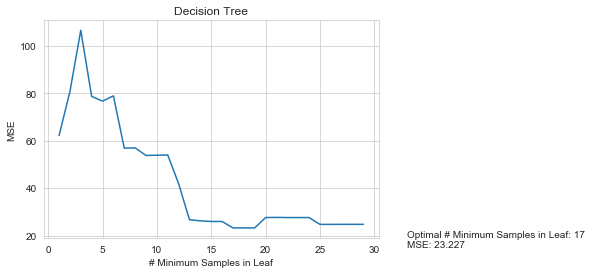

In [95]:
##### Decision Tree #####

X = pat_df.drop('Case Count',axis=1)
y = pat_df['Case Count']
mse_cv = []
mse_cv_mean = []

for p in np.arange(1, 30):
    for itrain, itest in kf.split(X):
        X_train, X_test, y_train, y_test = X.iloc[itrain], X.iloc[itest], y.iloc[itrain], y.iloc[itest]
        dtr = DecisionTreeRegressor(min_samples_leaf = p)
        dtr.fit(X_train, y_train)
        val = mean_squared_error(y_test, dtr.predict(X_test))
        mse_cv_mean.append(val)
    mse_cv.append(np.mean(val))
    
plt.plot(np.arange(1, 30), mse_cv)
plt.title('Decision Tree')
plt.xlabel('# Minimum Samples in Leaf')
plt.ylabel('MSE')
s = ('Optimal # Minimum Samples in Leaf: ' + str(mse_cv.index(min(mse_cv)) + 1) + '\nMSE: ' + str(round(min(mse_cv), 3)))
plt.text(33, 15, s)
plt.show()

From our analysis, we concluded that 17 produced the lowest MSE value. Therefore, we are going to utilize 17 and move forward with the analysis.

#### My Model

Now that we have determined the best model to be a Decision Tree regressor with 17 minimum in sample leaves, we can now fit our model to all of our data. After doing so we will look at other model metrics such as RMSE and MAE. Both of these metrics are important to also be analyzed because the RMSE shows model fit and model standard deviation, and MAE will show us the mean absolute error of our model.  <br>

In [97]:
X = pat_df.drop('Case Count',axis=1)
y = pat_df['Case Count']

# instantiate model
leaves = 17
tree = DecisionTreeRegressor(min_samples_leaf=leaves, random_state = 801)

# X is our explanatory from the train, y is our response from the train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=801)

scores_mse = cross_val_score(tree, X_train, y_train, cv=20, scoring='neg_mean_squared_error')
scores_mae = cross_val_score(tree, X_train, y_train, cv=20, scoring='neg_mean_absolute_error')
mse_cv = -1*scores_mse.mean()
rmse_cv = np.sqrt(mse_cv)
mae_cv = -1*scores_mae.mean()

print('MSE: ' + str(mse_cv) + '\nRMSE: ' + str(rmse_cv) + '\nMAE: ' + str(mae_cv))


MSE: 30.351828845396888
RMSE: 5.5092493903795
MAE: 3.818357988223761


After tuning our model, we found that the model has an RMSE of approximately 5.51 and MAE of 3.82 which indicates that the model predicts fairly well. The RMSE is a metric for model fit. The lower, the better. The entire range of the target is 38, so if our RMSE is 5.51, then our model does relatively well. The MAE implies that the model is off on average by 3.82 cases which is relatively strong. <br>

#### Important Features

Next, we will look at which features are the most important when determining the number of sessions a patient will need. To do this we will extract the feature importance scores from our model and compare them to their respective feature and look at the top 10 in descending order.

In [101]:
# fit model with entire data

leaves = 17
tree = DecisionTreeRegressor(min_samples_leaf=leaves, random_state = 801)

X = pat_df.drop('Case Count', axis = 1)
y = pat_df['Case Count']

tree.fit(X, y)

# Create Important Features Data Frame
feats = X.columns
imp_scores = pd.Series(tree.feature_importances_)
feat_imp = pd.DataFrame()

feat_imp['Features'] = feats
feat_imp['Importance Score'] = imp_scores

In [102]:
top_10 = feat_imp.sort_values('Importance Score', ascending=False).head(10)

top_10

,Features,Importance Score
358,Working for Center for Disability and Access_Prefer not to disclose,0.354930
369,Advocate_A,0.166708
366,Client status_Active (currently engaged),0.129085
305,Veteran Status_No,0.093361
372,Advocate_D,0.064797
395,Case Type Modified_Violence,0.048313
371,Advocate_C,0.038333
0,Enrollment Status_Enrolled,0.027530
311,Immigration Status_3,0.026703
355,Fraternity/Sorority Affiliated?_No,0.025278


The top 10 features show that those who worked with advocate A, D, or C had higher case counts. Also those whose case type was 'Violence' experienced longer case sessions. <br>

The number 1 most important feature is surprising and shows bias in the data. If someone chooses that they prefer not to disclose if they work for the Center for Disability should not be a strong determining feature. <br>

To make this model stronger and more informative, more questions should be dropped from the dataset. Only questions of importance should be kept. <br>

#### Summary of Model Performance

In summary the model performed strongly for this dataset. This model can be used to predict the number of cases a patient will have when coming to the clinic with relatively low error. <br>

However, the model may not do well practically. Many of the top 10 features such as Enrollment Status and Veteran Status should not be strong features since majority of the observations in this dataset were of the same Enrollment Status and Veteran Status. <br>

### Conclusions & Next Steps

In conclusion of this analysis, the model is strong for its own dataset, but practically it is weak and subject to class skewness in the data. Many of the categories are heavily skewed in one class and therefore are affecting the analysis. For a more robust analysis, a more well rounded dataset with more equal quanitities in each categorical feature would be needed. <br>

Of the top 10 features of the analysis, patients listed as having been victims of violence tended to have more case sessions. This would be an interesting analysis to research more. For this analysis we were limited on some features and condensed the case types into 4 groups from 8. With more data, the case types could be separated and utilized individually in the analysis. This could then answer if some case types will require more case sessions than others. <br>

A Decision Tree model can be finnicky and have varying results with small changes. An ensemble method might be a better approach to having a more robust model. A future analysis could use an ADA or Gradient Boosting method or a type of Bagging to have an even better more accurate model. <br>

This dataset could also be utilized for a classification problem. Instead of predicting the number of cases, the data could be utilized to predict the case type of a patient given the data and the number of sessions the patient has had. <br>

A cluster analysis could also be utilized to retrieve more information from this dataset. The cluster analysis could be used to identify similarities in features among patients and case types. <br>